In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#chargement fichiers
df = pd.read_csv("./data/rating.csv", sep="\t",encoding="utf-8-sig", error_bad_lines=False, low_memory=False)


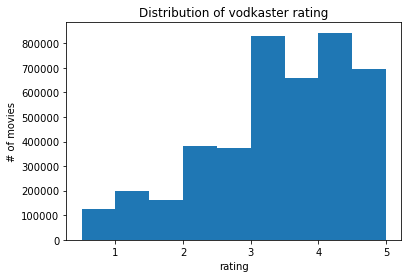

In [2]:
# Distrib des avg_ratings (1-5)
plt.hist(df.value,bins=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.xlabel("rating")
plt.ylabel("# of movies")
plt.title("Distribution of vodkaster rating")

#On affiche
plt.show()

In [3]:
df[:5]

,id,user_id,value,object_id,object_type,creation_date
0,64,73,1.0,3618,film,2008-12-04 10:38:12
1,66,14,4.0,3911,film,2008-12-04 11:58:17
2,67,14,3.0,4828,film,2008-12-04 12:39:05
3,68,6842,3.0,6909,film,2008-12-04 14:17:30
4,73,6842,4.0,9371,film,2008-12-04 15:03:51


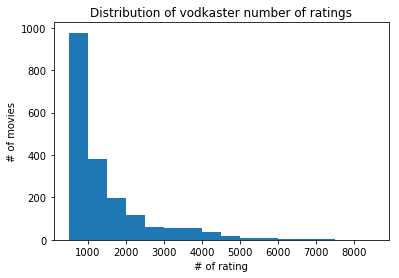

In [5]:
# Distrib du nb de rating (=popularité des films)
rg = df.groupby('object_id').count()['id']
plt.hist(rg,bins=range(500,9000,500))
plt.xlabel("# of rating")
plt.ylabel("# of movies")
plt.title("Distribution of vodkaster number of ratings")

#On affiche
plt.show()

In [11]:
#Jointure avec les films vodkaster
dff = pd.read_csv("./data/vod_films.csv", sep="\t",encoding="utf-8", error_bad_lines=False, low_memory=False)
dff = dff.loc[:,{'id','title','year'}]
dff = dff.rename(columns = {'id':'object_id'})
dff = dff.merge(df,how='inner',on='object_id')
dff = dff.loc[:,{'object_id','title','year','user_id','value'}]
dff = dff.rename(columns = {'object_id':'film_id'})
dff[:5]
df=dff

b'Skipping line 22345: expected 28 fields, saw 29\n'


,value,film_id,title,year,user_id
0,1.0,1269,Le Chaos,2007,67781
1,3.5,1269,Le Chaos,2007,756947
2,2.0,1269,Le Chaos,2007,907563
3,4.0,1269,Le Chaos,2007,929770
4,4.0,1275,Alexandrie... New York,2004,737070


In [17]:
#Combien d'utilisateurs distincts ?
len(df.user_id.unique())

25857

In [23]:
#Creation du dataset des films moins bien notés par les utilisateurs ayant vu ce titre 
titre = "Eros + Massacre"
dft = df[df["title"]==titre]

In [57]:
df_other = pd.DataFrame()
df_other = dft.loc[:,{'value','user_id'}]
df_other = df_other.rename(columns = {'value':'titre_ref_score'})
df_other = df_other.merge(dff,how='inner',on='user_id')
df_other = df_other.rename(columns = {'value':'titre_other_score'})
df_other['score_ref_moins_other'] = df_other.titre_ref_score-df_other.titre_other_score

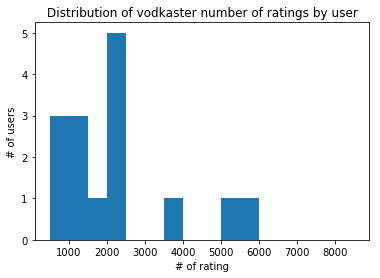

In [58]:
# Distrib du nb de note par utilisateur
rg = df_other.groupby('user_id').count()['year']
plt.hist(rg,bins=range(500,9000,500))
plt.xlabel("# of rating")
plt.ylabel("# of users")
plt.title("Distribution of vodkaster number of ratings by user")

#On affiche
plt.show()

#COnclusion : pour le titre de "eros + massacre", le film a été vu par des gros power users (3k films par user en moyenne oO)

In [71]:
#quels sont les autres films qui ont été les plus vus par ceux qui ont vu 'eros + massacre' ?
df_other.groupby('title').count()['user_id'].sort_values(ascending=False)[:10]
#en toute logique on a les films les plus populaires qui apparaissent....il faudrait virer les films 'trop vus'
#ceux qui apparaissent plus de fois que le nb de users correspondent à des films qui ont le même titre
#pour eliminer le pb il suffit de grouper par identifiant unique

title
Scarface                 30
Les Misérables           29
King Kong                29
Dracula                  25
Macbeth                  23
La Belle et la Bête      22
Solaris                  22
Les Visiteurs            21
La Planète des singes    21
Robin des Bois           21
Name: user_id, dtype: int64

In [72]:
df_other[:10]

,user_id,titre_ref_score,titre_other_score,film_id,title,year,score_ref_moins_other
0,183088,5.0,3.0,1461,Les Anges déchus,1995,2.0
1,183088,5.0,1.0,1529,Les Cendres du temps - Redux,2008,4.0
2,183088,5.0,4.0,1541,2046,2004,1.0
3,183088,5.0,5.0,1553,In the Mood for Love,2000,0.0
4,183088,5.0,4.0,1557,Happy Together,1997,1.0
5,183088,5.0,1.0,1559,Les Cendres du temps,1996,4.0
6,183088,5.0,3.0,1565,Nos années sauvages,1991,2.0
7,183088,5.0,4.0,1571,Chungking Express,1995,1.0
8,183088,5.0,5.0,1883,Three times,2004,0.0
9,183088,5.0,3.0,1893,Café lumière,2004,2.0


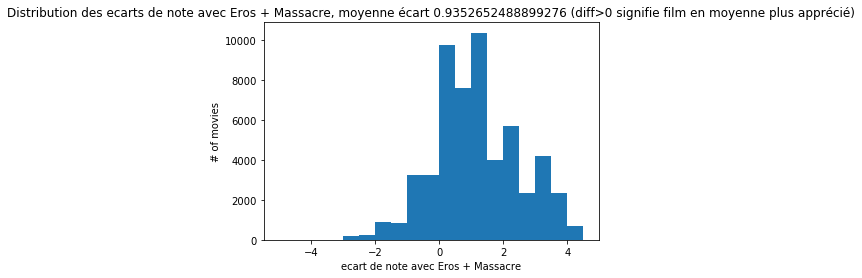

In [89]:
#Comment les users ont t'ils apprécié ce film par rapport au reste de leur collection ?
plt.hist(df_other.score_ref_moins_other,bins=np.arange(-5,5,0.5))
plt.xlabel("ecart de note avec "+titre)
plt.ylabel("# of movies")
plt.title("Distribution des ecarts de note avec {}, moyenne écart {} (diff>0 signifie film en moyenne plus apprécié)".format(titre, df_other.score_ref_moins_other.mean()))

#On affiche
plt.show()

#Pour Eros+M, le film est en moyenne aprécié 1 cran au dessus des autres films vus par les users l'ayant noté

In [104]:
#Quels sont films les plus proches et les plus lointains en terme de note
dft = df_other.groupby('title')['score_ref_moins_other'].agg(['mean','count']).reset_index().sort_values(ascending=False, by ='mean')
#n'affichons que ceux qui ont été vus au moins par 5 users
dft[dft['count']>5]
#intepretation : c'est interessant parce que ça commence à "polariser" les gouts, très clairement 
#les films les plus lointains négativement sont des boues et les plus lointains positivements
#sont des films "artsy" et vus uniquement par un public de connaisseurs
#et si on enlève le filtre d'un film vu par aux moins 5 users, on voit plus spécifiquement pointer des films vus par des
#connaisseurs en cinéma japonais

,title,mean,count
1096,Banlieue 13 ultimatum,3.833333,6
14755,Taxi 4,3.785714,7
5030,Iznogoud,3.666667,6
14754,Taxi 3,3.625000,8
16384,Vercingétorix : la légende du druide roi,3.583333,6
10551,"Les Rivières pourpres 2, les anges de l'Apocal...",3.583333,6
842,Astérix aux jeux olympiques,3.562500,8
1095,Banlieue 13,3.555556,9
3090,Double zéro,3.500000,7
6503,La Beuze,3.500000,6
